# Erlotinib IC50 Modeling – Full Pipeline

This notebook contains the **full pipeline** we built to model Erlotinib IC50.

Steps:
1. Load the enriched Erlotinib dataset (`Erlotinib_Biological_Enriched.csv`).
2. Clean and validate the IC50 values.
3. Prepare features (drop IDs, one‑hot encode categories, handle missing values).
4. Split the data into train/test sets.
5. Train three baseline models (Linear Regression, Random Forest, Gradient Boosting).
6. Evaluate models on a hold‑out test set and with 5‑fold cross‑validation.
7. Tune the Gradient Boosting model using RandomizedSearchCV.
8. Interpret the tuned model using feature importance.

In [1]:
# === 0. Imports ===
import pandas as pd          # work with tables of data
import numpy as np           # numerical tools (arrays, math)

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt  # plotting library

np.set_printoptions(precision=3, suppress=True)  # nicer number printing


In [11]:
# === 1. Load Erlotinib dataset ===
# Make sure this CSV is in the same folder as the notebook.
data_path = "Erlotinib_Biological_Enriched.csv"

df = pd.read_csv(data_path)     # read the CSV file into a DataFrame
print("Raw shape:", df.shape)   # show (rows, columns)

# quickly inspect:
df.head()


Raw shape: (393, 10)


,COSMIC_ID,IC50,Cell Line Name,GDSC Desc1,GDSC Desc2,TCGA Desc,Genetic Feature,IS Mutated,Recurrent Gain Loss,Genes in Segment
0,684057,3.966813,ES5,bone,ewings_sarcoma,UNCLASSIFIED,cnaPANCAN1,0,gain,"C19orf12,CCNE1,PLEKHF1,POP4,TSHZ3,UQCRFS1,URI1..."
1,684059,2.692090,ES7,bone,ewings_sarcoma,UNCLASSIFIED,cnaPANCAN1,0,gain,"C19orf12,CCNE1,PLEKHF1,POP4,TSHZ3,UQCRFS1,URI1..."
2,684062,2.477990,EW-11,bone,ewings_sarcoma,UNCLASSIFIED,cnaPANCAN1,0,gain,"C19orf12,CCNE1,PLEKHF1,POP4,TSHZ3,UQCRFS1,URI1..."
3,684072,2.033564,SK-ES-1,bone,ewings_sarcoma,UNCLASSIFIED,cnaPANCAN1,0,gain,"C19orf12,CCNE1,PLEKHF1,POP4,TSHZ3,UQCRFS1,URI1..."
4,687448,2.966007,COLO-829,skin,melanoma,SKCM,cnaPANCAN1,0,gain,"C19orf12,CCNE1,PLEKHF1,POP4,TSHZ3,UQCRFS1,URI1..."


In [3]:
# === 2. Clean IC50 and remove ID columns ===

# 2.1 Remove ID-like columns (COSMIC ID, etc.)
id_cols = [c for c in df.columns if ("cosmic" in c.lower() or "id" in c.lower())]
df = df.drop(columns=id_cols, errors="ignore")
print("Columns after dropping ID-like columns:", len(df.columns))

# 2.2 Make sure IC50 is numeric (non-numeric values become NaN)
df["IC50"] = pd.to_numeric(df["IC50"], errors="coerce")

# 2.3 Keep only rows where IC50 is valid (finite and >= 0)
mask = np.isfinite(df["IC50"]) & (df["IC50"] >= 0)
df = df[mask].copy()

print("Rows after cleaning IC50:", df.shape[0])
print("Any NaNs left in IC50?", df["IC50"].isna().sum())

# 2.4 Separate target (y) and features (X)
if "IC50" not in df.columns:
    raise ValueError("IC50 not found – check your column names")

y_raw = df["IC50"].astype(float).values
print("Any non-finite in y_raw?", np.sum(~np.isfinite(y_raw)))

# Use log(IC50) as target to reduce skew
y = np.log1p(y_raw)
print("Any non-finite in y after log1p?", np.sum(~np.isfinite(y)))

X = df.drop(columns=["IC50"])
print("Feature columns (before encoding):", X.shape[1])


Columns after dropping ID-like columns: 9
Rows after cleaning IC50: 378
Any NaNs left in IC50? 0
Any non-finite in y_raw? 0
Any non-finite in y after log1p? 0
Feature columns (before encoding): 8


In [4]:
# === 3. Encode categorical variables and handle missing values ===

# Find columns with text values (e.g., tissue names)
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)

# Turn text categories into 0/1 dummy columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Remove columns that are all NaN, and fill remaining NaN with 0
X = X.dropna(axis=1, how="all")
X = X.fillna(0)

print("Feature matrix shape:", X.shape)
print("Number of features:", X.shape[1])


Categorical columns: ['Cell Line Name', 'GDSC Desc1', 'GDSC Desc2', 'TCGA Desc', 'Genetic Feature', 'Recurrent Gain Loss', 'Genes in Segment']
Feature matrix shape: (378, 537)
Number of features: 537


In [5]:
# === 4. Split into train and test sets ===

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 302
Test size: 76


In [6]:
# === 5. Train baseline models ===

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting (default)": GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        random_state=42
    )
}

def eval_model(name, model):
    """Fit the model, predict on test data, print R² and RMSE."""
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{name} – Test R²: {r2:.3f}, RMSE (log-space): {rmse:.3f}")
    return r2, rmse

print("\n=== Single train/test evaluation ===")
base_results = {}
for name, mdl in models.items():
    base_results[name] = eval_model(name, mdl)

base_results



=== Single train/test evaluation ===
Linear Regression – Test R²: -0.172, RMSE (log-space): 0.292
Random Forest – Test R²: -0.072, RMSE (log-space): 0.280
Gradient Boosting (default) – Test R²: 0.089, RMSE (log-space): 0.258


{'Linear Regression': (-0.17205445943543562, 0.2924866677701533),
 'Random Forest': (-0.07193585687468795, 0.2797155292334909),
 'Gradient Boosting (default)': (0.08875776184492856, 0.25789866850185683)}

In [7]:
# === 6. 5-fold cross-validation ===

cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== 5-fold CV R² (log-space) ===")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)
    print(f"{name}: mean R² = {scores.mean():.3f}, std = {scores.std():.3f}")



=== 5-fold CV R² (log-space) ===
Linear Regression: mean R² = -0.152, std = 0.156
Random Forest: mean R² = -0.116, std = 0.072
Gradient Boosting (default): mean R² = -0.005, std = 0.102


In [8]:
# === 7. Hyperparameter tuning for Gradient Boosting ===

print("\n=== Hyperparameter search for Gradient Boosting ===")
gbr = GradientBoostingRegressor(random_state=42)

param_dist = {
    "n_estimators": [200, 300, 400, 600],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "min_samples_leaf": [1, 3, 5]
}

search = RandomizedSearchCV(
    gbr,
    param_distributions=param_dist,
    n_iter=25,
    scoring="r2",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search.fit(X_train, y_train)
best_gbr = search.best_estimator_
print("Best params:", search.best_params_)

y_pred_test = best_gbr.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Tuned GB – Test R²: {r2_test:.3f}, RMSE (log-space): {rmse_test:.3f}")

cv_scores_best = cross_val_score(best_gbr, X, y, cv=cv, scoring="r2", n_jobs=-1)
print(f"Tuned GB – CV R² mean: {cv_scores_best.mean():.3f}, std: {cv_scores_best.std():.3f}")



=== Hyperparameter search for Gradient Boosting ===
Best params: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.01}
Tuned GB – Test R²: 0.062, RMSE (log-space): 0.262
Tuned GB – CV R² mean: 0.041, std: 0.068


In [9]:
# === 8. Feature importance for tuned Gradient Boosting ===

# Get importance scores for every feature
importances = pd.Series(best_gbr.feature_importances_, index=X.columns)

# Keep the top 20 most important features
top20 = importances.sort_values(ascending=False).head(20)
top20


GDSC Desc2_osteosarcoma                          0.107176
Cell Line Name_NOS-1                             0.067429
Cell Line Name_MOLT-16                           0.059775
Genetic Feature_cnaPANCAN357                     0.054459
Cell Line Name_D-502MG                           0.052933
Genes in Segment_ACVR2A,MBD5,ORC4                0.051837
GDSC Desc2_oesophagus                            0.043647
TCGA Desc_ESCA                                   0.043566
Cell Line Name_A253                              0.038166
TCGA Desc_SCLC                                   0.036119
Cell Line Name_HEL                               0.034335
GDSC Desc2_lung_small_cell_carcinoma             0.033643
Cell Line Name_TE-5                              0.028678
GDSC Desc2_lung_NSCLC_squamous_cell_carcinoma    0.028406
Cell Line Name_NCI-H1869                         0.024032
Cell Line Name_NCI-H1355                         0.022720
TCGA Desc_LUSC                                   0.020519
Cell Line Name

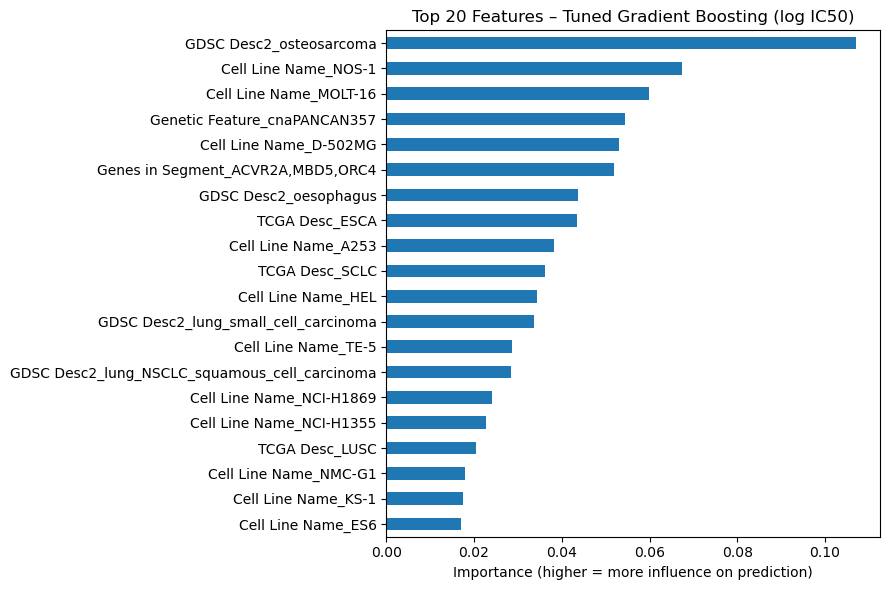

In [10]:
# Plot the top 20 features

plt.figure(figsize=(10, 6))
top20.sort_values().plot(kind="barh")
plt.title("Top 20 Features – Tuned Gradient Boosting (log IC50)")
plt.xlabel("Importance (higher = more influence on prediction)")
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


## 9. Summary

- We cleaned and prepared the Erlotinib dataset.
- We modeled **log(IC50)** as the target to handle skew.
- We compared several models and found that tuned Gradient Boosting performed best.
- We used cross-validation to check generalization.
- We inspected feature importance to see which tissues and genetic features drive Erlotinib response.